In [1]:
import numpy as np
import torch as th
import torchvision
import blobfile as bf
import PIL
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F


In [2]:
def _list_image_files_recursively(data_dir):
    results = []
    for entry in sorted(bf.listdir(data_dir)):
        full_path = bf.join(data_dir, entry)
        ext = entry.split(".")[-1]
        if "." in entry and ext.lower() in ["jpg", "jpeg", "png", "gif"]:
            results.append(full_path)
        elif bf.isdir(full_path):
            results.extend(_list_image_files_recursively(full_path))
    return results

def get_image(path, resize_mode=PIL.Image.ANTIALIAS):
    with bf.BlobFile(path, "rb") as f:
        pil_image = PIL.Image.open(f)
        pil_image.load()
    pil_image = pil_image.convert("RGB")
    image = pil_image.resize((64, 64), resize_mode)
    image = np.array(image)

    return image

plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(30, 30))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

def face_segment(raw_pil_image, face_segment_image, segment_part):

        face_segment_anno = np.array(face_segment_image)
        bg = (face_segment_anno == 0)
        skin = (face_segment_anno == 1)
        l_brow = (face_segment_anno == 2)
        r_brow = (face_segment_anno == 3)
        l_eye = (face_segment_anno == 4)
        r_eye = (face_segment_anno == 5)
        eye_g = (face_segment_anno == 6)
        l_ear = (face_segment_anno == 7)
        r_ear = (face_segment_anno == 8)
        ear_r = (face_segment_anno == 9)
        nose = (face_segment_anno == 10)
        mouth = (face_segment_anno == 11)
        u_lip = (face_segment_anno == 12)
        l_lip = (face_segment_anno == 13)
        neck = (face_segment_anno == 14)
        neck_l = (face_segment_anno == 15)
        face = np.logical_or.reduce((skin, l_brow, r_brow, l_eye, r_eye, eye_g, l_ear, r_ear, ear_r, nose, mouth, u_lip, l_lip, neck, neck_l))

        if segment_part == 'faceseg_face':
            return face * np.array(raw_pil_image)
        elif segment_part == 'faceseg_face&hair':
            return ~bg * np.array(raw_pil_image)

def blur(img, k, sigma_list):
    if img.shape[0] != 3:
        img = np.transpose(img, (2, 0, 1))

    blur_imgs = [th.tensor(img)]
    for sigma in sigma_list:
        blur_kernel = torchvision.transforms.GaussianBlur(kernel_size=k, sigma=sigma)
        blur_img = blur_kernel(th.tensor(img))

        blur_imgs.append(blur_img)

    print("Sigma list : ", sigma_list)
    grid = torchvision.utils.make_grid(th.stack(blur_imgs, dim=0))
    batch = th.stack(blur_imgs, dim=0)
    return batch, grid


def save_segment(img_name, raw_img, segment_part, segment_img, sigma_list, k):
    seg_img = face_segment(raw_img, segment_img, segment_part=segment_part)
    batch_seg_blur, face_img_grid = blur(seg_img, k=k, sigma_list=sigma_list)
    import os
    os.makedirs(f"./{img_name}/{segment_part}/", exist_ok=True)
    sigma_list = [0] + list(sigma_list)
    for idx, img in enumerate(batch_seg_blur):
        torchvision.utils.save_image(img/255, fp=f'./{img_name}/{segment_part}/{segment_part}_{sigma_list[idx]}_blur_img.png')


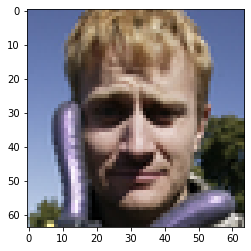

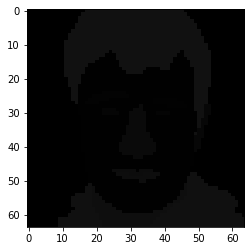

Sigma list :  [0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5.  5.5 6.  6.5 7.  7.5 8.  8.5 9.
 9.5]
Sigma list :  [0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5.  5.5 6.  6.5 7.  7.5 8.  8.5 9.
 9.5]


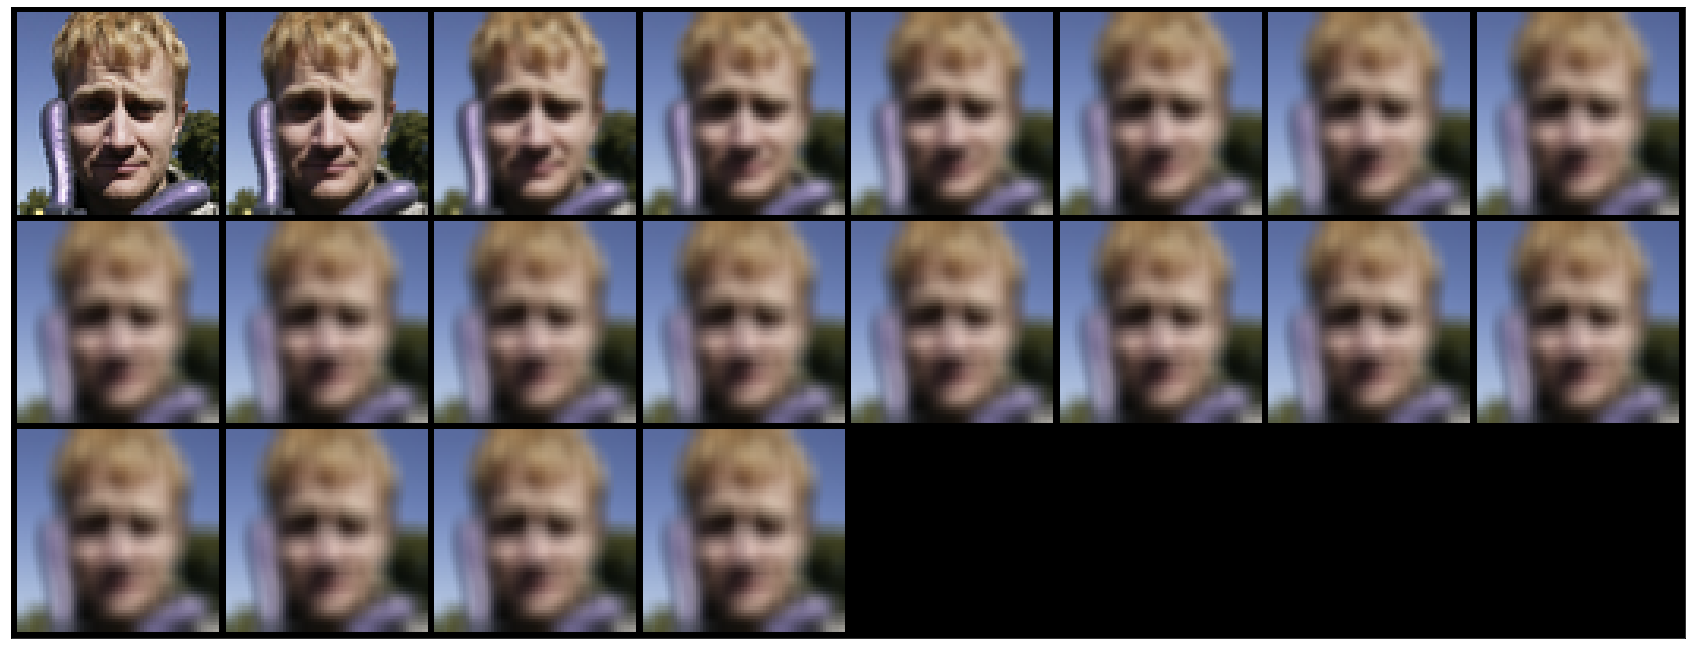

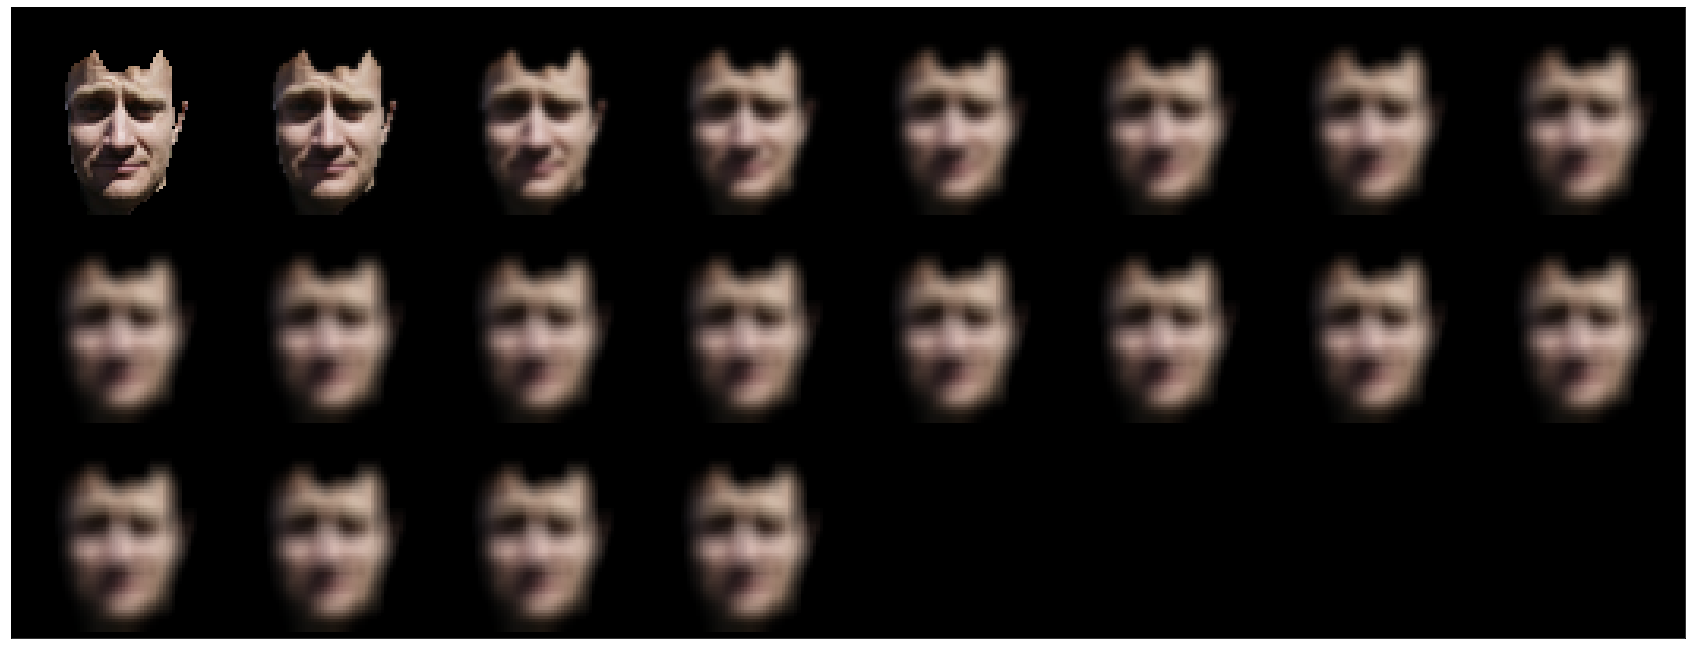

In [7]:
from cv2 import resize

set_ = 'valid'
data_dir = f'/data/mint/ffhq_256_with_anno/ffhq_256/{set_}'
images = _list_image_files_recursively(data_dir)
segment_dir = f'/data/mint/ffhq_256_with_anno/face_segment/{set_}/'
segment_images = _list_image_files_recursively(segment_dir)

image_dict = {}
for raw_path, segment_path in zip(images, segment_images):
    assert raw_path.split('/')[-1] == segment_path.split('/')[-1].split('_')[-1].replace('.png', '.jpg')
    img_name = raw_path.split('/')[-1]
    image_dict[img_name] = {}
    image_dict[img_name]['raw'] = raw_path
    image_dict[img_name]['segment'] = segment_path

raw_img = get_image(image_dict['60065.jpg']['raw'], resize_mode=PIL.Image.ANTIALIAS)
raw_img_tmp = raw_img.copy()
segment_img = get_image(image_dict['60065.jpg']['segment'], resize_mode=PIL.Image.NONE)
plt.imshow(raw_img)
plt.show()

plt.imshow(segment_img)
plt.show()
k = int(raw_img.shape[0] * 0.1)
k = k if k%2 != 0 else k+1
sigma_list = np.arange(0.5, 10, 0.5)

batch_raw_blur, raw_img_grid = blur(raw_img, k=k, sigma_list=sigma_list)
show(raw_img_grid)


segment_part = 'faceseg_face'
face_img = face_segment(raw_img_tmp, segment_img, segment_part=segment_part)
batch_face_blur, face_img_grid = blur(face_img, k=k, sigma_list=sigma_list)
show(face_img_grid)

import os
img_name = '60065.jpg'
os.makedirs(f"./{img_name}/{segment_part}/", exist_ok=True)
sigma_list = [0] + list(sigma_list)
for idx, img in enumerate(batch_face_blur):
    torchvision.utils.save_image(img/255, fp=f'./{img_name}/{segment_part}/{segment_part}_{sigma_list[idx]}_blur_img.png')

# Normalize image from [0, 1] => [-1, 1]
# norm = torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
# print(th.max(norm(th.tensor(img/255))))
# print(th.min(norm(th.tensor(img/255))))


In [11]:
set_ = 'valid'
data_dir = f'/data/mint/ffhq_256_with_anno/ffhq_256/{set_}'
images = _list_image_files_recursively(data_dir)
segment_dir = f'/data/mint/ffhq_256_with_anno/face_segment/{set_}/'
segment_images = _list_image_files_recursively(segment_dir)

image_dict = {}
for raw_path, segment_path in zip(images, segment_images):
    assert raw_path.split('/')[-1] == segment_path.split('/')[-1].split('_')[-1].replace('.png', '.jpg')
    img_name = raw_path.split('/')[-1]
    image_dict[img_name] = {}
    image_dict[img_name]['raw'] = raw_path
    image_dict[img_name]['segment'] = segment_path


def generate_blur(img_name, segment_part):
    raw_img = get_image(image_dict[img_name]['raw'], resize_mode=PIL.Image.ANTIALIAS)
    raw_img_tmp = raw_img.copy()
    segment_img = get_image(image_dict[img_name]['segment'], resize_mode=PIL.Image.NONE)

    k = int(raw_img.shape[0] * 0.1)
    k = k if k%2 != 0 else k+1
    sigma_list = np.arange(0.5, 10, 0.5)
    save_segment(img_name=img_name, raw_img=raw_img, segment_part=segment_part, segment_img=segment_img, sigma_list=sigma_list, k=k)

generate_blur(img_name='60065.jpg', segment_part='faceseg_face')
generate_blur(img_name='60065.jpg', segment_part='faceseg_face&hair')

Sigma list :  [0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5.  5.5 6.  6.5 7.  7.5 8.  8.5 9.
 9.5]


IndexError: index 19 is out of bounds for axis 0 with size 19